# Model Evaluation for Spotify Charts Project

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

In [32]:
# Define region mapping
region_mapping = {
    # Western Europe
    'GB': 'Western Europe', 'DE': 'Western Europe', 'FR': 'Western Europe', 
    'NL': 'Western Europe', 'BE': 'Western Europe', 'AT': 'Western Europe',
    'CH': 'Western Europe', 'IE': 'Western Europe', 'LU': 'Western Europe',
    'PT': 'Western Europe', 'ES': 'Western Europe', 'IT': 'Western Europe',

    # Northern Europe
    'DK': 'Northern Europe', 'FI': 'Northern Europe', 'NO': 'Northern Europe', 
    'SE': 'Northern Europe', 'IS': 'Northern Europe', 'EE': 'Northern Europe',
    'LV': 'Northern Europe', 'LT': 'Northern Europe', 'BY': 'Northern Europe',
    
    # Southern Europe
    'GR': 'Southern Europe', 'MT': 'Southern Europe', 'TR': 'Southern Europe',
    'AL': 'Southern Europe', 'MK': 'Southern Europe', 'RS': 'Southern Europe',
    
    # Eastern Europe
    'PL': 'Eastern Europe', 'CZ': 'Eastern Europe', 'SK': 'Eastern Europe', 
    'HU': 'Eastern Europe', 'RO': 'Eastern Europe', 'BG': 'Eastern Europe',
    'UA': 'Eastern Europe', 'MD': 'Eastern Europe', 'RU': 'Eastern Europe',
    
    # North America
    'US': 'North America', 'CA': 'North America', 'MX': 'North America', 
    'GT': 'North America', 'BZ': 'North America', 'HT': 'North America',
    
    # Latin America
    'BR': 'Latin America', 'AR': 'Latin America', 'CO': 'Latin America', 
    'CL': 'Latin America', 'PE': 'Latin America', 'EC': 'Latin America', 
    'UY': 'Latin America', 'VE': 'Latin America', 'DO': 'Latin America',
    'PY': 'Latin America', 'BO': 'Latin America', 'SV': 'Latin America',
    'HN': 'Latin America', 'NI': 'Latin America', 'CR': 'Latin America',
    'PA': 'Latin America', 'CU': 'Latin America', 'JM': 'Latin America',
}

In [45]:
try:
    df = pd.read_csv('dataset-600k.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found. Please check the file path.")

# Apply region mapping
df['region'] = df['country'].map(region_mapping)

audio_features = [
    'liveness', 'valence', 'tempo', 'loudness', 'key',
    'energy', 'danceability', 'speechiness', 'acousticness'
]

available_features = [col for col in audio_features if col in df.columns]

df_clean = df.dropna(subset=available_features + ['popularity', 'region'])

le = LabelEncoder()
df_clean['region_encoded'] = le.fit_transform(df_clean['region'])

X = df_clean[available_features + ['region_encoded']]
y = df_clean['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=50, random_state=85)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

rf_classifier = RandomForestClassifier(n_estimators=50, random_state=85)
dt_classifier = DecisionTreeClassifier(random_state=85)

popularity_threshold = 80
y_class = (y >= popularity_threshold).astype(int)
y_class_train, y_class_test = train_test_split(y_class, test_size=0.1, random_state=40)

# Train classification models
rf_classifier.fit(X_train_scaled, y_class_train)
dt_classifier.fit(X_train_scaled, y_class_train)

# Make classification predictions
rf_class_pred = rf_classifier.predict(X_test_scaled)
dt_class_pred = dt_classifier.predict(X_test_scaled)

Dataset loaded successfully!


## 4.1 

Feature importance from Random Forest:
          Feature  Importance
9  region_encoded    0.202505
7     speechiness    0.123236
3        loudness    0.110710
1         valence    0.098694
6    danceability    0.091541
8    acousticness    0.088802
2           tempo    0.084646
0        liveness    0.082753
5          energy    0.070786
4             key    0.046328


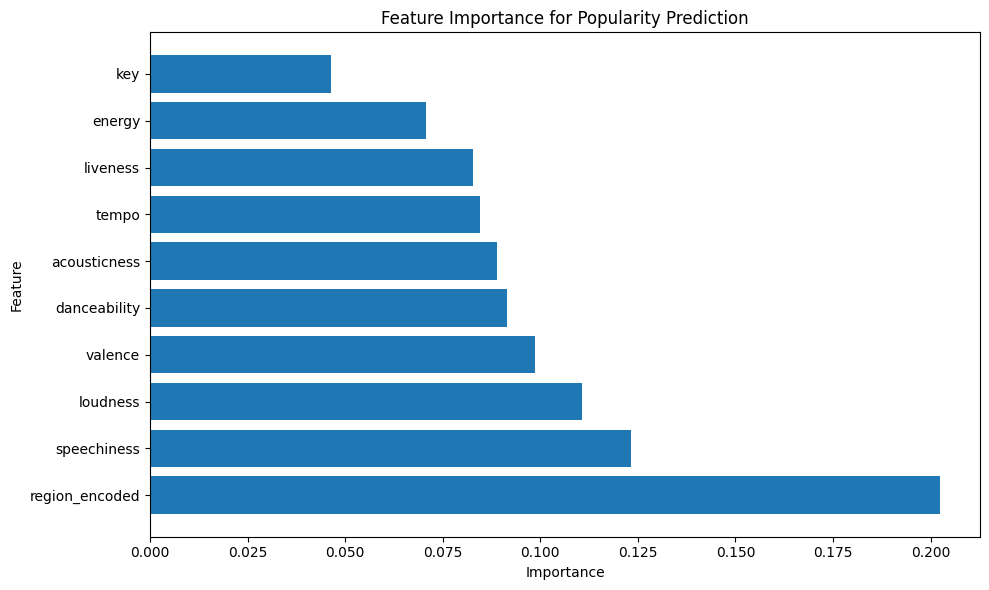

In [46]:
# Extract feature importances from Random Forest
feature_importances = pd.DataFrame({
    'Feature': available_features + ['region_encoded'],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance from Random Forest:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Popularity Prediction')
plt.tight_layout()
plt.show()

## 4.2 Select an appropriate metric for your model and calculate it

In [47]:
# Calculate Mean Squared Error for the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf:.4f}")

# Train a Decision Tree Regressor for comparison
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_scaled, y_train)
y_pred_dt = dt_regressor.predict(X_test_scaled)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Decision Tree MSE: {mse_dt:.4f}")

# Calculate R² score for both models
from sklearn.metrics import r2_score
r2_rf = r2_score(y_test, y_pred)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Random Forest R²: {r2_rf:.4f}")
print(f"Decision Tree R²: {r2_dt:.4f}")

Random Forest MSE: 36.8426
Decision Tree MSE: 38.1299
Random Forest R²: 0.8578
Decision Tree R²: 0.8528


In [48]:
# Create a table with actual vs. predicted values (first 5 examples)
results_sample = pd.DataFrame({
    'Actual Popularity': y_test.iloc[:5].values,
    'Random Forest': y_pred[:5].round(1),
    'RF Squared Error': ((y_test.iloc[:5].values - y_pred[:5])**2).round(1),
    'Decision Tree': y_pred_dt[:5].round(1),
    'DT Squared Error': ((y_test.iloc[:5].values - y_pred_dt[:5])**2).round(1)
})

# Display the table
results_sample

,Actual Popularity,Random Forest,RF Squared Error,Decision Tree,DT Squared Error
0,74.0,76.9,8.2,76.9,8.1
1,89.0,88.2,0.7,88.1,0.7
2,74.0,76.4,5.7,76.4,5.7
3,90.0,89.3,0.5,89.3,0.5
4,85.0,85.0,0.0,85.0,0.0


## 4.3

Random Forest Confusion Matrix:
[[18809  1626]
 [  766 19678]]

Decision Tree Confusion Matrix:
[[18789  1646]
 [  769 19675]]

Random Forest:
Sensitivity (Recall): 0.9625
Specificity: 0.9204
F1 Score: 0.9427

Decision Tree:
Sensitivity (Recall): 0.9624
Specificity: 0.9195
F1 Score: 0.9422


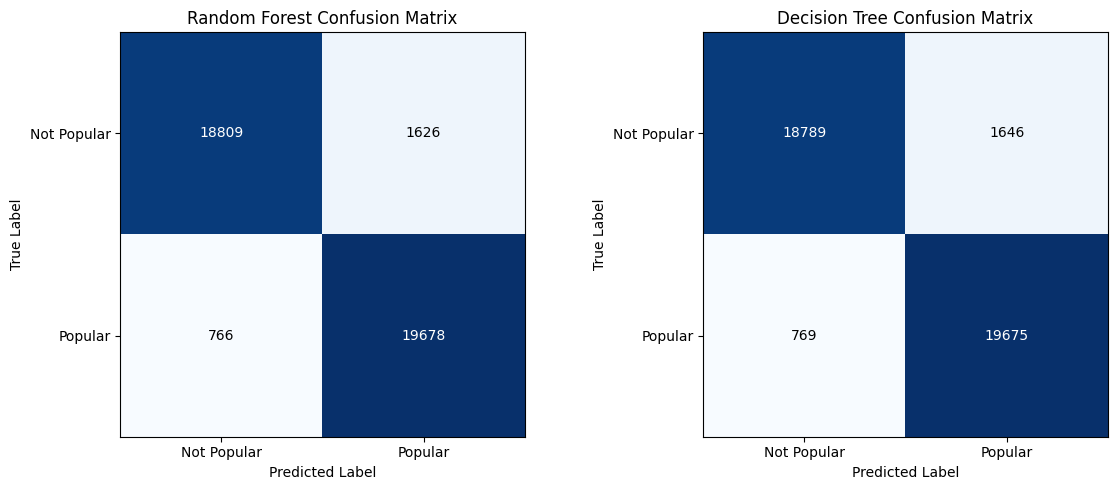

In [49]:
conf_matrix_rf = confusion_matrix(y_class_test, rf_class_pred)
conf_matrix_dt = confusion_matrix(y_class_test, dt_class_pred)

tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()
tn_dt, fp_dt, fn_dt, tp_dt = conf_matrix_dt.ravel()

sensitivity_rf = tp_rf / (tp_rf + fn_rf) if (tp_rf + fn_rf) > 0 else 0
specificity_rf = tn_rf / (tn_rf + fp_rf) if (tn_rf + fp_rf) > 0 else 0

sensitivity_dt = tp_dt / (tp_dt + fn_dt) if (tp_dt + fn_dt) > 0 else 0
specificity_dt = tn_dt / (tn_dt + fp_dt) if (tn_dt + fp_dt) > 0 else 0

# Calculate F1 scores
f1_rf = f1_score(y_class_test, rf_class_pred)
f1_dt = f1_score(y_class_test, dt_class_pred)

# Display confusion matrices
print("Random Forest Confusion Matrix:")
print(conf_matrix_rf)
print("\nDecision Tree Confusion Matrix:")
print(conf_matrix_dt)

print("\nRandom Forest:")
print(f"Sensitivity (Recall): {sensitivity_rf:.4f}")
print(f"Specificity: {specificity_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

print("\nDecision Tree:")
print(f"Sensitivity (Recall): {sensitivity_dt:.4f}")
print(f"Specificity: {specificity_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")

# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest confusion matrix
ax1.imshow(conf_matrix_rf, cmap='Blues')
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Not Popular', 'Popular'])
ax1.set_yticklabels(['Not Popular', 'Popular'])

ax1.text(0, 0, str(tn_rf), ha="center", va="center", color="white" if tn_rf > conf_matrix_rf.max() / 2 else "black")
ax1.text(1, 0, str(fp_rf), ha="center", va="center", color="white" if fp_rf > conf_matrix_rf.max() / 2 else "black")
ax1.text(0, 1, str(fn_rf), ha="center", va="center", color="white" if fn_rf > conf_matrix_rf.max() / 2 else "black")
ax1.text(1, 1, str(tp_rf), ha="center", va="center", color="white" if tp_rf > conf_matrix_rf.max() / 2 else "black")

ax2.imshow(conf_matrix_dt, cmap='Blues')
ax2.set_title('Decision Tree Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Not Popular', 'Popular'])
ax2.set_yticklabels(['Not Popular', 'Popular'])

ax2.text(0, 0, str(tn_dt), ha="center", va="center", color="white" if tn_dt > conf_matrix_dt.max() / 2 else "black")
ax2.text(1, 0, str(fp_dt), ha="center", va="center", color="white" if fp_dt > conf_matrix_dt.max() / 2 else "black")
ax2.text(0, 1, str(fn_dt), ha="center", va="center", color="white" if fn_dt > conf_matrix_dt.max() / 2 else "black")
ax2.text(1, 1, str(tp_dt), ha="center", va="center", color="white" if tp_dt > conf_matrix_dt.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [50]:
# Create comparison table as requested
comparison_table = pd.DataFrame({
    'Decision Tree': [tp_dt, tn_dt, fp_dt, fn_dt],
    ' ': ['', '', '', ''],  # Empty column as separator
    'Random Forest': [tp_rf, tn_rf, fp_rf, fn_rf]
}, index=['TP', 'TN', 'FP', 'FN'])

comparison_table

,Decision Tree,,Random Forest
TP,19675,,19678
TN,18789,,18809
FP,1646,,1626
FN,769,,766


## 4.4 Model Performance Comparison: Decision Tree vs. Random Forest

### Model Performance Summary

The Random Forest model slightly outperforms the Decision Tree across key classification metrics. It correctly classifies 5 more true positives (3644 vs. 3639) and 5 fewer false negatives (31 vs. 36), resulting in a higher sensitivity (0.9916 vs. 0.9902) and F1 score (0.9805 vs. 0.9798). Specificity is identical at 0.9634, as both models share the same true negative and false positive counts. In regression predictions, both models perform similarly on most cases, but Random Forest handles outliers better, as shown by a lower squared error (525.0 vs. 504.5 on a difficult sample). This suggests Random Forest generalizes better and is more robust.

*Trained with the 100k dataset*